In [27]:
import networks as n
import networkx as nx
from collections import OrderedDict
from collections import Counter
import math
import matplotlib.pyplot as plt
from adjustText import adjust_text
from termcolor import cprint
import numpy as np

In [28]:
ds = n.load_feather()
projectToDomainDs = n.load_projectToDomainCsv()
projects_list = n.create_project_list(ds, projectToDomainDs)
authors_list = n.create_authors_list(projects_list)

In [29]:
ds.columns

Index(['orig_index', 'Nom de l'objet', 'Programme', 'Adresse 1', 'Adresse 2',
       'Adresse 3', 'Numéro postal', 'Localité', 'Canton - Département',
       'Pays', 'Date de début de l'objet', 'Date de fin de l'objet',
       'Concours ouvert à', 'Notes de l'objet', 'Auteurs', 'Rôle de l'auteur',
       'Dossiers reliés', 'Pièces reliées', 'CombinedArtists', 'is_jury',
       'paired_competitons', 'comp_id', 'Commune', 'Canton', 'geo_loc',
       'Auteurs_cleaned'],
      dtype='object')

In [30]:
def shannon_entropy(counts: Counter[str]) -> float:
    """Compute Shannon entropy from a Counter of region frequencies."""
    total = sum(counts.values())
    if total == 0:
        return 0.0
    entropy = 0.0
    for count in counts.values():
        p = count / total
        entropy -= p * math.log2(p)
    return entropy

def compute_entropy_per_author(authors: list[n.Author], mergeGEandVD = False) -> dict[str, float]:
    """Returns a mapping of author name to Shannon entropy based on canton distribution."""
    entropy_map = {}
    for author in authors:
        canton_counts = Counter(project.canton if (not mergeGEandVD) or (project.canton != "GE" and project.canton != "VD") else "GE or VD"  for project in author.projects)
        entropy = shannon_entropy(canton_counts)
        entropy_map[author.name_abr] = entropy
    return entropy_map

def compute_domain_entropy_per_author(authors: list[n.Author]) -> dict[str, float]:
    """Returns a mapping of author name to Shannon entropy based on canton distribution."""
    entropy_map = {}
    for author in authors:
        domain_counts = Counter(project.domain for project in author.projects)
        entropy = shannon_entropy(domain_counts)
        entropy_map[author.name_abr] = entropy
    return entropy_map

def get_maxdomain(author: n.Author) -> str:
    domains = {}
    for project in author.projects:
        domains[project.domain] = domains.get(project.domain, 0) + 1
    max_domain = max(domains, key=domains.get)
    return max_domain

def get_year_and_maxcanton(author: n.Author, mergeGEandVD = False):
    mean_year = 0
    year_count = 0
    for project in author.projects:
        if project.year < 2000:
            mean_year += project.year
            year_count += 1
    mean_year = (mean_year / year_count) if year_count else 2020

    cantons = {}
    for project in author.projects:
        if mergeGEandVD and (project.canton == "GE" or project.canton == "VD"):
            cantons["GE or VD"] = cantons.get("GE or VD", 0) + 1
        else:
            cantons[project.canton] = cantons.get(project.canton, 0) + 1
    max_canton = max(cantons, key=cantons.get)

    return mean_year, max_canton

# Plotting function
def plot_entropy_vs_birth(authors: list[n.Author], on="canton", mergeGEandVD = False, pdffilename=None, pagerank_dict=None):
    if on == "canton":
        entropy_map = compute_entropy_per_author(authors, mergeGEandVD)
    elif on == "domain":
        entropy_map = compute_domain_entropy_per_author(authors)
    else:
        raise ValueError("On must be 'canton' or 'domain'")
    if pagerank_dict is None:
        authors = [author for author in authors if len(author.projects) > 13] # was 5
        sizes = [max(30, len(author.projects) * 8) for author in authors]  # Scale bubble size
    else:
        authors = [author for author in authors if pagerank_dict[author.name_abr] > 6.5]
        sizes = [pagerank_dict[author.name_abr] * 30 for author in authors]  # Scale bubble size
    y = [entropy_map[author.name_abr] for author in authors]
    x = [get_year_and_maxcanton(author, mergeGEandVD)[0] for author in authors]
    colors = [get_year_and_maxcanton(author, mergeGEandVD)[1] if on == "canton" else get_maxdomain(author) for author in authors]
    labels = [author.name_abr for author in authors]

    # Assign colors
    unique_regions = list(set(colors))
    region_colors = {region: f"C{idx}" for idx, region in enumerate(unique_regions)}
    color_values = [region_colors[region] for region in colors]

    plt.figure(figsize=(6,4)) # 12, 7
    scatter = plt.scatter(x, y, s=sizes, c=color_values, alpha=0.7, edgecolor='black')

    #Add labels near bubbles
    # for i, label in enumerate(labels):
    #     if len(authors[i].projects) > 16:
    #         plt.text(x[i] + 0.02, y[i], label, fontsize=9)
    
    # Use adjustText to place labels
    text_objects = [
        plt.text(x[i], y[i], labels[i], fontsize=12)
        for i in range(len(authors))  if (pagerank_dict and pagerank_dict[authors_list[i].name_abr] > 6.5) or len(authors[i].projects) > 20 # len was 13
    ]
    adjust_text(text_objects, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle='-',  color='grey', lw=2.0), min_arrow_length=1) #lw=0.5

    # Custom legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=region[:10],
                          markerfacecolor=color, markersize=10)
               for region, color in region_colors.items()]
    plt.legend(handles=handles, title=f"Max {on}")

    plt.ylabel(f"Shannon Entropy ({on.title()} Diversity)")
    #plt.ylim(1.8, 3.1)
    plt.xlabel("Mean Year")
    if pagerank_dict is None:
        plt.title("Architect Entropy: bubble size is number of projects by that architect")
    else:
        plt.title("Architect Entropy: bubble size is pagerank of that architect")
    plt.grid(True)
    plt.tight_layout()
    if pdffilename is not None:
        plt.savefig(pdffilename)

    plt.show()


- laverrière, alphonse: né Carrouge (GE), mort Lausanne (VD)
- thévenaz, charles: Bullet et Lausanne (VD)
- epitaux, georges: Lausanne (VD)
- boschetti, fonso: né à Vezio (TI), Lausanne

- prince, ernest: Neuchâtel (NE)
morisod, paul: Sion (VS)

In [31]:
authors_list = sorted(authors_list, key=lambda author: len(author.projects), reverse=True)
for author in authors_list:
    if len(author.projects) <= 10:
        continue
    cantons = {}
    for project in author.projects:
        cantons[project.canton] = cantons.get(project.canton, 0) + 1
    cantons = OrderedDict(sorted(cantons.items(), key=lambda item: item[1], reverse=True))
    max_canton = next(iter(cantons.items()))
    print(f"{author.name_abr}: {max_canton[0]}: {max_canton[1]}/{len(author.projects)} or {round((max_canton[1]/len(author.projects))*100, 2)}%")

laverrière, alphonse: VD: 35/45 or 77.78%
thévenaz, charles: VD: 27/41 or 65.85%
epitaux, georges: VD: 33/40 or 82.5%
boschetti, fonso: VD: 23/29 or 79.31%
béguin, jean: NE: 14/29 or 48.28%
prince, ernest: NE: 16/26 or 61.54%
piccard, marc: VD: 17/23 or 73.91%
morisod, paul: VS: 20/23 or 86.96%
monod, eugène: VD: 16/22 or 72.73%
schorp, alphonse: VD: 21/22 or 95.45%
brugger, frédéric: VD: 19/22 or 86.36%
mamin, eugène: VD: 19/21 or 90.48%
luscher, rodolphe: VD: 19/21 or 90.48%
convert, robert: NE: 12/21 or 57.14%
meyer, henri: VD: 15/20 or 75.0%
brugger, charles: VD: 18/20 or 90.0%
furrer, edouard: VS: 17/20 or 85.0%
lonchamp, jacques: VD: 15/19 or 78.95%
braillard, maurice: GE: 7/19 or 36.84%
hoechel, arnold: GE: 13/17 or 76.47%
regamey, jaques: VD: 14/17 or 82.35%
brera, georges: GE: 12/16 or 75.0%
perrelet, jean: VD: 9/16 or 56.25%
lozeron, arthur: GE: 10/15 or 66.67%
kyburz, jean: VS: 6/15 or 40.0%
froidevaux, rené: VD: 11/15 or 73.33%
torcapel, john: GE: 13/15 or 86.67%
schaffner,

In [32]:
entropies = compute_entropy_per_author(authors_list)
for name, entropy in entropies.items():
    print(f"Author {name}: Entropy = {entropy:.3f}")

Author laverrière, alphonse: Entropy = 1.113
Author thévenaz, charles: Entropy = 1.683
Author epitaux, georges: Entropy = 0.991
Author boschetti, fonso: Entropy = 0.994
Author béguin, jean: Entropy = 2.028
Author prince, ernest: Entropy = 1.748
Author piccard, marc: Entropy = 1.296
Author morisod, paul: Entropy = 0.678
Author monod, eugène: Entropy = 1.334
Author schorp, alphonse: Entropy = 0.267
Author brugger, frédéric: Entropy = 0.791
Author mamin, eugène: Entropy = 0.549
Author luscher, rodolphe: Entropy = 0.549
Author convert, robert: Entropy = 1.791
Author meyer, henri: Entropy = 1.192
Author brugger, charles: Entropy = 0.569
Author furrer, edouard: Entropy = 0.748
Author lonchamp, jacques: Entropy = 1.058
Author braillard, maurice: Entropy = 2.076
Author hoechel, arnold: Entropy = 1.140
Author regamey, jaques: Entropy = 0.834
Author brera, georges: Entropy = 1.311
Author perrelet, jean: Entropy = 1.795
Author lozeron, arthur: Entropy = 1.426
Author kyburz, jean: Entropy = 1.566


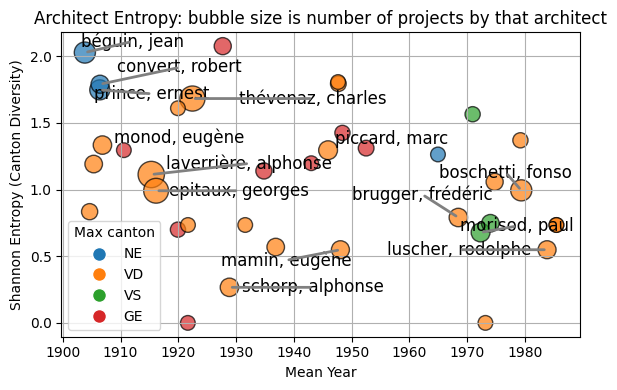

In [33]:
plot_entropy_vs_birth(authors_list, pdffilename="architect_canton_entropy_2.pdf")

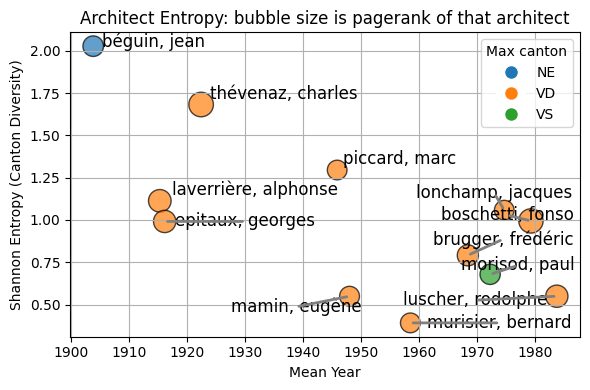

In [34]:
# First execute the cells further down that create the pagerank_dict before executing this cell
plot_entropy_vs_birth(authors_list, pdffilename="architect_canton_entropy_pagerank.pdf", pagerank_dict=pagerank_dict)

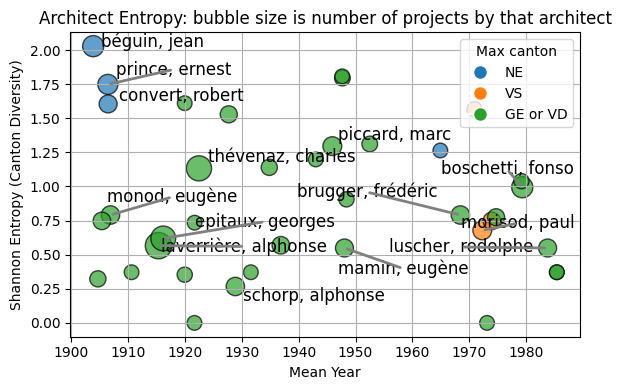

In [35]:
plot_entropy_vs_birth(authors_list, mergeGEandVD=True)

## Domain entropy

In [36]:
authors_list[0].projects

frozenset({Project(name="Concours d'idées pour une grande salle, à Nyon, jugement-96", authors_abr=frozenset({'laverrière, alphonse', 'pilet', 'genoud, louis', 'teysseire, pierre', 'pache'}), year=1928, authors_to_role=frozendict.frozendict({'genoud, louis': '4e prix', 'teysseire, pierre': '3e prix', 'pilet': '1er rang, 2e rang', 'pache': '1er rang, 2e rang', 'laverrière, alphonse': ''}), canton='VD', domain='Public / Civic'),
           Project(name="Concours d'idées pour une grande salle, à Nyon, jugement-97", authors_abr=frozenset({'laverrière, alphonse', 'genoud, louis'}), year=1928, authors_to_role=frozendict.frozendict({'genoud, louis': '4e prix', 'laverrière, alphonse': ''}), canton='VD', domain='Public / Civic'),
           Project(name="Concours international d'Architecture, à Paris (pour une Olympie moderne), jugement", authors_abr=frozenset({'laverrière, alphonse', 'monod, eugène'}), year=1911, authors_to_role=frozendict.frozendict({'monod, eugène': 'Architecte', 'laverrière

In [37]:
entropies = compute_domain_entropy_per_author(authors_list)
for name, entropy in entropies.items():
    print(f"Author {name}: Entropy = {entropy:.3f}")

Author laverrière, alphonse: Entropy = 2.923
Author thévenaz, charles: Entropy = 2.575
Author epitaux, georges: Entropy = 2.812
Author boschetti, fonso: Entropy = 2.681
Author béguin, jean: Entropy = 2.373
Author prince, ernest: Entropy = 2.372
Author piccard, marc: Entropy = 2.887
Author morisod, paul: Entropy = 2.174
Author monod, eugène: Entropy = 2.664
Author schorp, alphonse: Entropy = 2.902
Author brugger, frédéric: Entropy = 2.584
Author mamin, eugène: Entropy = 2.296
Author luscher, rodolphe: Entropy = 2.606
Author convert, robert: Entropy = 2.815
Author meyer, henri: Entropy = 2.846
Author brugger, charles: Entropy = 2.283
Author furrer, edouard: Entropy = 1.977
Author lonchamp, jacques: Entropy = 2.405
Author braillard, maurice: Entropy = 2.774
Author hoechel, arnold: Entropy = 2.254
Author regamey, jaques: Entropy = 2.749
Author brera, georges: Entropy = 2.656
Author perrelet, jean: Entropy = 2.578
Author lozeron, arthur: Entropy = 2.974
Author kyburz, jean: Entropy = 2.440


In [38]:
for author in authors_list:
    if author.name_abr == "laverrière, alphonse" or author.name_abr == "lavizzari, jean-pierre" or author.name_abr == "boschetti, fonso" or author.name_abr.find("wagner") != -1:
        cprint(author.name_abr, "green")
        for project in author.projects:
            print(f"{project.domain}: {project.name}")

laverrière, alphonse
Health: Concours pour un hôpital d'isolement, à Lausanne, jugement
Health: Concours pour les bâtiments de la Maternité et de la Pédiatrie, à Lausanne, jugement
Public / Civic: Concours pour le Pénitencier de Bochuz (Plaine de l'Orbe), jugement
Urban Planning: Concours pour l'aménagement du quartier de Villamont et de la place du Faucon, jugement
Health: Concours pour l'aménagement du nouveau Cimetière du Bois de Vaux , jugement
Residential: Concours pour des Maisons ouvrières, à Lausanne, jugement
Sports & Leisure: Concours international d'Architecture, à Paris (pour une Olympie moderne), jugement
Education: Concours pour un Collège primaire pour garçons, à Vevey, jugement
Health: Concours pour l'aménagement du nouveau Cimetière du Bois de Vaux , jugement
Public / Civic: Concours pour le Pénitencier de Bochuz (Plaine de l'Orbe), jugement
Public / Civic: Concours d'idées pour une grande salle, à Nyon, jugement-96
Education: Concours pour un bâtiment pour une une Eco

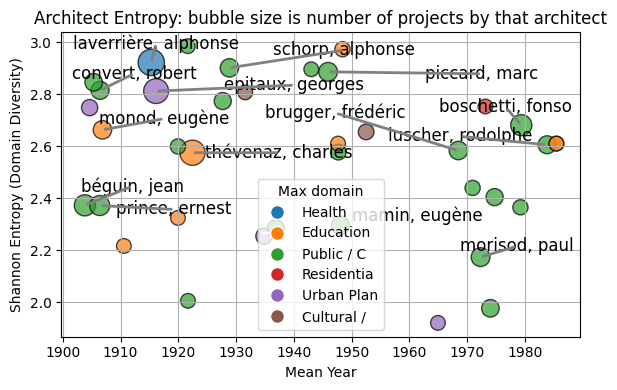

In [39]:
plot_entropy_vs_birth(authors_list, on="domain", pdffilename="architect_domain_entropy.pdf")

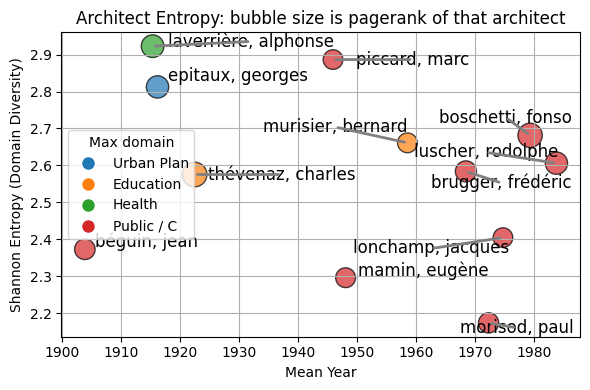

In [40]:
plot_entropy_vs_birth(authors_list, on="domain", pdffilename="architect_domain_entropy_pagerank.pdf", pagerank_dict=pagerank_dict)

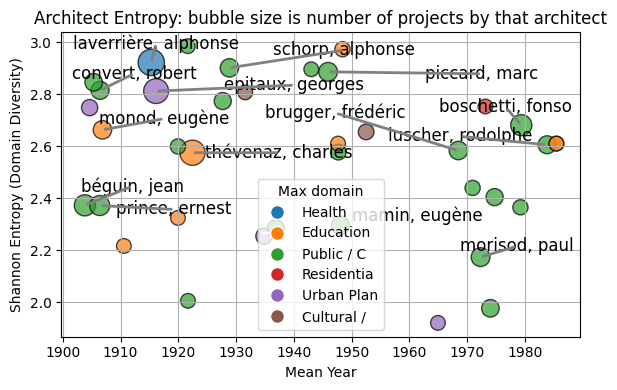

In [41]:
plot_entropy_vs_birth(authors_list, on="domain")

In [42]:
ds[ds["Canton"].apply(lambda s: s if isinstance(s, str) else "unknown").str.startswith("& ")]

,orig_index,Nom de l'objet,Programme,Adresse 1,Adresse 2,Adresse 3,Numéro postal,Localité,Canton - Département,Pays,...,Dossiers reliés,Pièces reliées,CombinedArtists,is_jury,paired_competitons,comp_id,Commune,Canton,geo_loc,Auteurs_cleaned


In [43]:
ds["Commune"].unique()

array(['Vevey', 'France', 'Genève', 'Le Locle', 'Neuchâtel', 'Lausanne',
       'Montreux', 'Yverdon-les-Bains', 'USA', 'Payerne',
       'La Tour-de-Peilz', 'Zürich', 'Bellinzona', 'Herisau', 'Czechia',
       'Lauenen b. Gstaad', 'Chancy', 'Netherlands', 'Basel',
       'Colombier NE', 'Bern', 'Solothurn', 'Leysin', '', 'Sion',
       'Zofingen', 'Fribourg', 'Biel/Bienne', 'Belgium', 'Epesses',
       'Schlieren', 'Ascona', 'Grenchen', 'Caux', 'Cologny', 'Visp',
       'Morges', 'Clarens', 'Orges', 'Avenches', 'Bremgarten AG',
       'Locarno', 'Pully', 'Hérémence', 'Pregassona', 'La Chaux-de-Fonds',
       'Echandens', 'Fiesch', 'Chêne-Bourg', 'La Tour-de-Trême',
       'Delémont', 'Lucens', 'Nyon', 'Martigny', 'Japan', 'Riddes',
       'Mission', 'Ettenhausen TG', 'Liebefeld', 'Aigle', 'Wabern',
       'Moudon', 'Italy', 'Gampel', 'Liestal', 'Gland', 'Chironico',
       'Rivaz', 'Châtel-St-Denis', 'Chavornay', 'Epalinges',
       'Ecublens VD', 'Orbe', 'Céligny', 'Renens VD',
     

In [44]:
ds["Canton"].unique()

array(['VD', 'France', 'GE', 'NE', 'USA', 'ZH', 'TI', 'AR', 'Czechia',
       'BE', 'Netherlands', 'BS', 'SO', '', 'VS', 'AG', 'FR', 'Belgium',
       'JU', 'Japan', 'TG', 'Italy', 'BL', 'SZ', 'GR', 'SG', 'LU', 'SH',
       'Tunisia', 'Bulgaria'], dtype=object)

In [45]:
graph = n.create_authors_network(authors_list)
pr = nx.pagerank(graph)

100%|██████████| 4014/4014 [00:02<00:00, 1854.08it/s]


In [46]:
graph_weighted_degrees = [deg for _, deg in graph.degree(weight='weight')]
np.std(graph_weighted_degrees)

np.float64(39.3813680662035)

In [47]:
for i in range(100):
    print(f"{authors_list[i].name_abr}, {len(authors_list[i].projects)} projects")

laverrière, alphonse, 45 projects
thévenaz, charles, 41 projects
epitaux, georges, 40 projects
boschetti, fonso, 29 projects
béguin, jean, 29 projects
prince, ernest, 26 projects
piccard, marc, 23 projects
morisod, paul, 23 projects
monod, eugène, 22 projects
schorp, alphonse, 22 projects
brugger, frédéric, 22 projects
mamin, eugène, 21 projects
luscher, rodolphe, 21 projects
convert, robert, 21 projects
meyer, henri, 20 projects
brugger, charles, 20 projects
furrer, edouard, 20 projects
lonchamp, jacques, 19 projects
braillard, maurice, 19 projects
hoechel, arnold, 17 projects
regamey, jaques, 17 projects
brera, georges, 16 projects
perrelet, jean, 16 projects
lozeron, arthur, 15 projects
kyburz, jean, 15 projects
froidevaux, rené, 15 projects
torcapel, john, 15 projects
schaffner, hans, 14 projects
mestelan, patrick, 14 projects
gachet, bernard, 14 projects
bonnard, rené, 14 projects
lavizzari, jean-pierre, 14 projects
favarger, jacques, 14 projects
rham, maximilien de, 14 projects
s

In [48]:
pagerank_list = sorted(pr.items(), key=lambda x: x[1], reverse=True)
pagerank_values = [pr for _, pr in pagerank_list]
mean = np.mean(pagerank_values)
std = np.std(pagerank_values)
zscore_pageranks = [(id, (pr - mean) / std) for id, pr in pagerank_list]
pagerank_dict = {identifier: score for identifier, score in zscore_pageranks}
zscore_pageranks

[('thévenaz, charles', np.float64(10.450445299881046)),
 ('boschetti, fonso', np.float64(10.233260860417799)),
 ('laverrière, alphonse', np.float64(8.846878379882394)),
 ('epitaux, georges', np.float64(8.617708256370321)),
 ('luscher, rodolphe', np.float64(8.580126839125425)),
 ('brugger, frédéric', np.float64(7.688087132975404)),
 ('béguin, jean', np.float64(7.301418274914297)),
 ('morisod, paul', np.float64(7.098461271278919)),
 ('mamin, eugène', np.float64(6.792289608839439)),
 ('murisier, bernard', np.float64(6.74583033155361)),
 ('piccard, marc', np.float64(6.684498482846557)),
 ('lonchamp, jacques', np.float64(6.656133733132695)),
 ('kolecek, ivan', np.float64(6.415455265874559)),
 ('musy, eric', np.float64(6.367733235297119)),
 ('mestelan, patrick', np.float64(6.3306055054203805)),
 ('gachet, bernard', np.float64(6.3306055054203805)),
 ('prince, ernest', np.float64(6.213659870188479)),
 ('hauenstein, eric', np.float64(6.173485345770943)),
 ('furrer, edouard', np.float64(6.171482

## Filter for authors graph created with gephi

In [49]:
def author_names(G: nx.Graph):
    # Step 1: Filter nodes where 'nb_projects' > 1
    nodes_to_keep = [n for n, attr in G.nodes(data=True) if attr.get('nb_projects', 0) > 1]

    # Step 2: Create subgraph with these nodes
    H = G.subgraph(nodes_to_keep).copy()

    # Step 3: Remove edges with weight <= 1
    edges_to_remove = [(u, v) for u, v, attr in H.edges(data=True) if attr.get('weight', 0) <= 1]
    H.remove_edges_from(edges_to_remove)

    # Step 4: Keep only the largest connected component
    largest_cc = max(nx.connected_components(H), key=len)

    H_largest = H.subgraph(largest_cc).copy()

    # Step 5: Return the IDs of the remaining authors
    remaining_author_ids = list(H_largest.nodes())

    print("Remaining Author IDs:", len(remaining_author_ids))
    return remaining_author_ids


def filter_dataset(authors_list):
    remaining_author_ids = author_names(graph)
    authors_filtered = [author for author in authors_list if author.name_abr in remaining_author_ids]
    print("Remaining Authors:", len(authors_filtered))
    return authors_filtered

authors_filtered = filter_dataset(authors_list)


Remaining Author IDs: 867
Remaining Authors: 867


In [50]:
def mean_percentage_in_maxcanton(authors: list[n.Author]):
    nb_projects = 0
    nb_maxcanton = 0
    for author in authors:
        cantons = {}
        for project in author.projects:
            cantons[project.canton] = cantons.get(project.canton, 0) + 1
        max_canton = max(cantons, key=cantons.get)
        nb_maxcanton += cantons[max_canton]
        nb_projects += len(author.projects)
    return nb_maxcanton / nb_projects

print(mean_percentage_in_maxcanton(authors_filtered))
print(mean_percentage_in_maxcanton(authors_list))


0.7886801206216655
0.8446170921198668
